# Ajust no lineal interactiu en Jupyter (model general) amb incerteses en X i Y

Aquest notebook està pensat perquè l’alumnat puga fer **ajustos no lineals** d’una manera interactiva (sliders + botó de fit) i, al mateix temps, tinga una guia mínima de teoria perquè siga **autocontingut**.

## Què fa
1. Carrega dades des d’un CSV (o de manera manual).
2. Mostra les dades amb barres d’error en **Y** i (opcionalment) en **X**.
3. Permet explorar el model canviant els paràmetres amb **sliders**.
4. Fa l’ajust i mostra:
   - paràmetres ajustats i incerteses,
   - χ² i χ² reduït,
   - residus,
   - banda d’incertesa aproximada al voltant del model ajustat (Monte Carlo a partir de la covariància).
5. (Opcional) guarda els resultats a un fitxer de text.

## Teoria mínima

### Ajust per mínims quadrats
Volem trobar els paràmetres **p** d’un model $ y = f(x; p) $ que s’ajuste a les dades $(x_i, y_i)$.  
En el cas més bàsic, minimitzem:
$$
S(p)=\sum_i (y_i - f(x_i;p))^2
$$

### Ajust ponderat i χ²
Si coneixem incerteses experimentals en **Y**, $\sigma_{y,i}$, fem servir:
$$
\chi^2(p)=\sum_i \left(\frac{y_i - f(x_i;p)}{\sigma_{y,i}}\right)^2
$$
Els punts amb menor incertesa pesen més.

### χ² reduït
$$
\chi^2_\mathrm{red}=\frac{\chi^2}{\nu}, \qquad \nu = N - n_p
$$
on $N$ és el nombre de punts i $n_p$ el nombre de paràmetres. Si el model és bo i les $\sigma_y$ són realistes, sovint $\chi^2_\mathrm{red}\approx 1$.

### Incerteses dels paràmetres (covariància)
Els ajustos donen una matriu de covariància $C$. Una aproximació a les incerteses 1σ és:
$$
\sigma_{p_k} \approx \sqrt{C_{kk}}
$$

### Errors en X
`curve_fit` assumeix que X és exacte. Si tens $\sigma_x$ apreciable, és millor usar **ODR** (Orthogonal Distance Regression), que considera errors en X i en Y.

## Com adaptar-ho a qualsevol funció
Ves a **"Definició del model"** i canvia:
- `model_func(x, *p)`
- `PARAM_NAMES`
- `P0`
- `BOUNDS` (opcional)

La resta del notebook funciona igual.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as w
from IPython.display import display, clear_output

from scipy.optimize import curve_fit
from scipy import odr

%matplotlib inline

# pandas és opcional (només per mostrar taules més boniques)
try:
    import pandas as pd
    HAVE_PANDAS = True
except Exception:
    HAVE_PANDAS = False

import sys, scipy, numpy
print("Versions:")
print(" Python:", sys.version.split()[0])
print(" NumPy :", numpy.__version__)
print(" SciPy :", scipy.__version__)
print(" pandas:", (pd.__version__ if HAVE_PANDAS else "no instal·lat"))


Versions:
 Python: 3.10.19
 NumPy : 2.2.6
 SciPy : 1.15.3
 pandas: 2.3.3


## Dades

### CSV recomanat
Amb capçalera:
- `x`
- `y`
- `sigma_y` (opcional)
- `sigma_x` (opcional)

Exemple:
```csv
x,y,sigma_y,sigma_x
820,0.12,0.01,1.0
840,0.16,0.01,1.0
...
```
Si el teu CSV té altres noms de columna, canvia la configuració.


In [2]:
# ----------------------
# CONFIGURACIÓ DE DADES
# ----------------------

DATA_MODE = "manual"                 # "csv" o "manual"
CSV_PATH  = "dades.csv"

# Noms de columnes al CSV
COL_X  = "x"
COL_Y  = "y"
COL_SY = "sigma_y"                # pot no existir
COL_SX = "sigma_x"                # pot no existir

# Si no hi ha sigma al CSV, defineix-la ací:
SIGMA_Y_MODE  = "constant"        # "constant" / "relative" / "none"
SIGMA_Y_CONST = 0.01
SIGMA_Y_REL   = 0.05

SIGMA_X_MODE  = "constant"        # "constant" / "relative" / "none"
SIGMA_X_CONST = 1.0
SIGMA_X_REL   = 0.001

# Dades manuals (si DATA_MODE="manual")
x_manual  = np.array([820, 840, 860, 880, 900, 920, 940, 960, 980, 1000], dtype=float)
y_manual  = np.array([0.12, 0.16, 0.22, 0.34, 0.62, 1.05, 0.68, 0.40, 0.26, 0.18], dtype=float)
sy_manual = 0.05*np.ones_like(y_manual)   # o None
sx_manual = 5.0*np.ones_like(x_manual)    # o None


In [3]:
def load_csv_generic(path, col_x, col_y, col_sy=None, col_sx=None):
    import csv
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        if reader.fieldnames is None:
            raise ValueError("El CSV no té capçalera.")
        fields = set(reader.fieldnames)
        if col_x not in fields or col_y not in fields:
            raise ValueError(f"Falten columnes: necessites '{col_x}' i '{col_y}'. Tens: {reader.fieldnames}")

        has_sy = (col_sy is not None) and (col_sy in fields)
        has_sx = (col_sx is not None) and (col_sx in fields)

        x_list, y_list, sy_list, sx_list = [], [], [], []
        for row in reader:
            if row[col_x].strip()=="" or row[col_y].strip()=="":
                continue
            x_list.append(float(row[col_x]))
            y_list.append(float(row[col_y]))
            if has_sy and row.get(col_sy, "").strip() != "":
                sy_list.append(float(row[col_sy]))
            if has_sx and row.get(col_sx, "").strip() != "":
                sx_list.append(float(row[col_sx]))

    x = np.array(x_list, dtype=float)
    y = np.array(y_list, dtype=float)
    sy = np.array(sy_list, dtype=float) if (has_sy and len(sy_list)==len(x_list)) else None
    sx = np.array(sx_list, dtype=float) if (has_sx and len(sx_list)==len(x_list)) else None
    return x, y, sy, sx


def build_sigma(ref, mode, const, rel):
    if mode == "none":
        return None
    if mode == "constant":
        return np.full_like(ref, float(const), dtype=float)
    if mode == "relative":
        return np.maximum(np.abs(ref)*float(rel), 1e-12)
    raise ValueError("mode ha de ser 'constant', 'relative' o 'none'")


# Carrega dades
if DATA_MODE.lower() == "csv":
    try:
        x, y, sy_csv, sx_csv = load_csv_generic(CSV_PATH, COL_X, COL_Y, COL_SY, COL_SX)
        print(f"Carregat: {CSV_PATH} ({len(x)} punts)")
    except FileNotFoundError:
        raise FileNotFoundError(
            f"No he trobat '{CSV_PATH}'. "
            "Posa el fitxer a la mateixa carpeta que el notebook o canvia CSV_PATH."
        )
else:
    x, y, sy_csv, sx_csv = x_manual, y_manual, sy_manual, sx_manual
    print(f"Dades manuals: {len(x)} punts")

# Ordena per X
idx = np.argsort(x)
x = x[idx]; y = y[idx]
if sy_csv is not None: sy_csv = sy_csv[idx]
if sx_csv is not None: sx_csv = sx_csv[idx]

# Sigma finals (si el CSV no les porta, usem la configuració)
sy = sy_csv if sy_csv is not None else build_sigma(y, SIGMA_Y_MODE, SIGMA_Y_CONST, SIGMA_Y_REL)
sx = sx_csv if sx_csv is not None else build_sigma(x, SIGMA_X_MODE, SIGMA_X_CONST, SIGMA_X_REL)

print("Rang x:", float(x.min()), "→", float(x.max()))
print("sigma_y:", ("sí" if sy is not None else "no"))
print("sigma_x:", ("sí" if sx is not None else "no"))


Dades manuals: 10 punts
Rang x: 820.0 → 1000.0
sigma_y: sí
sigma_x: sí


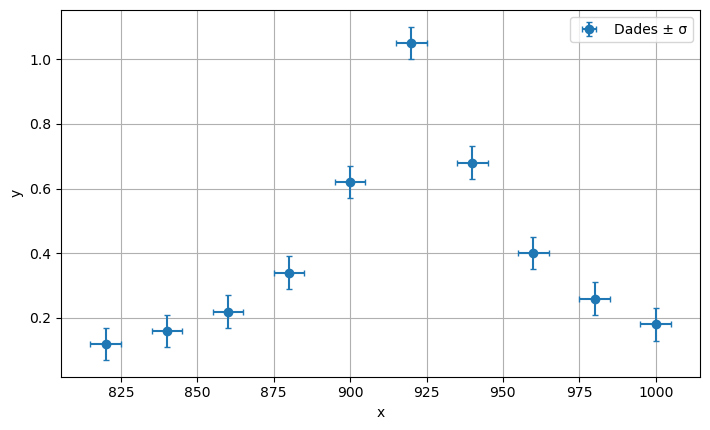

In [4]:
plt.figure(figsize=(7.2,4.4))
if sy is None and sx is None:
    plt.scatter(x, y, label="Dades")
else:
    plt.errorbar(x, y, yerr=sy, xerr=sx, fmt="o", capsize=2, label="Dades ± σ")
plt.xlabel(COL_X)
plt.ylabel(COL_Y)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Definició del model (canvia ací la funció)

Defineix:
- `model_func(x, *p)`
- `PARAM_NAMES`: noms dels paràmetres
- `P0`: valors inicials
- `BOUNDS`: límits per a `curve_fit` (opcional). Si no vols límits, posa `BOUNDS = None`.

### Exemple: ressonància tipus Lorentz
Pots substituir aquesta funció per qualsevol altra (exponencial, polinomi, sinusoide, etc.).


In [5]:
# ------------------------------------------------------
# MODEL (EXEMPLE). SUBSTITUEIX-HO PER QUALSEVOL FUNCIÓ
# ------------------------------------------------------

def model_func(x, Bp, xr, b, C):
    # y(x) = Bp / sqrt((xr^2-x^2)^2 + (2*b*x)^2) + C
    return Bp / np.sqrt((xr**2 - x**2)**2 + (2*b*x)**2) + C

PARAM_NAMES = ["Bp", "xr", "b", "C"]

# Valors inicials (pots posar-los a mà si vols)
def estimate_seeds_example(x, y):
    i_peak = int(np.argmax(y))
    xr = float(x[i_peak])
    n = len(y); k = max(1, n//10)
    C = float(np.mean(np.concatenate([y[:k], y[-k:]])))
    A_peak = float(y[i_peak] - C)
    A_peak = max(A_peak, 1e-12)
    y_half = C + A_peak/np.sqrt(2)

    # aproximació a FWHM (per estimar b)
    def interp_cross(i1, i2):
        x1, y1 = float(x[i1]), float(y[i1])
        x2, y2 = float(x[i2]), float(y[i2])
        if y2 == y1:
            return None
        t = (y_half - y1) / (y2 - y1)
        return (x1 + t*(x2 - x1)) if (0.0 <= t <= 1.0) else None

    x_left = None
    for i in range(i_peak, 0, -1):
        if (y[i]-y_half)*(y[i-1]-y_half) <= 0:
            x_left = interp_cross(i, i-1)
            if x_left is not None:
                break

    x_right = None
    for i in range(i_peak, len(y)-1):
        if (y[i]-y_half)*(y[i+1]-y_half) <= 0:
            x_right = interp_cross(i, i+1)
            if x_right is not None:
                break

    if x_left is not None and x_right is not None and x_right > x_left:
        fwhm = float(x_right - x_left)
        b = max(fwhm/2.0, 1e-12)
    else:
        b = max((float(x.max()-x.min()))/50.0, 1e-12)

    Bp = A_peak * 2.0 * b * xr
    return [Bp, xr, b, C]

P0 = estimate_seeds_example(x, y)

# Límits per a curve_fit (opcional). En ODR no s'apliquen directament.
BOUNDS = (
    [0.0, float(x.min()), 0.0, -np.inf],
    [np.inf, float(x.max()), np.inf, np.inf]
)
# Si no vols límits:
# BOUNDS = None

print("P0 =", P0)


P0 = [21949.870688601895, 920.0, 13.254752831281337, 0.15]


## Ajust: curve_fit o ODR
- Si no hi ha sigma_x, la opció habitual és `curve_fit`.
- Si hi ha sigma_x, la opció habitual és `odr`.
Pots seleccionar-ho manualment en el desplegable.


In [6]:
def choose_default_method(sx):
    return "odr" if sx is not None else "curve_fit"

DEFAULT_METHOD = choose_default_method(sx)
print("Mètode per defecte:", DEFAULT_METHOD)


Mètode per defecte: odr


## Interfície interactiva
- Sliders per als paràmetres
- Botó per fer el fit
- Resultats (resum + taula)
- Residus
- Banda d’incertesa (~68%) via Monte Carlo (a partir de la covariància)


In [7]:
# ---------------------------
# Utilitats per a covariància
# ---------------------------

def symmetrise(cov):
    return 0.5*(cov + cov.T)

def make_psd(cov, jitter=1e-15):
    # Projecta a PSD per estabilitzar el mostreig Monte Carlo
    cov = symmetrise(cov)
    w, V = np.linalg.eigh(cov)
    w_clip = np.clip(w, 0.0, None)
    cov_psd = (V * w_clip) @ V.T
    scale = float(np.max(np.diag(cov_psd))) if cov_psd.size else 1.0
    eps = jitter * (scale if scale > 0 else 1.0)
    cov_psd = cov_psd + eps*np.eye(cov_psd.shape[0])
    warn_non_psd = (np.min(w) < -1e-12*np.max(np.abs(w)))
    return cov_psd, warn_non_psd

def mc_band(x_grid, popt, pcov, n_draws=800, seed=12345):
    cov_psd, warn = make_psd(pcov)
    rng = np.random.default_rng(seed)
    draws = rng.multivariate_normal(mean=np.array(popt, float), cov=cov_psd, size=int(n_draws))
    ys = np.array([model_func(x_grid, *p) for p in draws])
    lo = np.percentile(ys, 16, axis=0)
    hi = np.percentile(ys, 84, axis=0)
    return lo, hi, warn


In [8]:
# ---------------------------
# Ajustos (curve_fit i ODR)
# ---------------------------

def fit_curve_fit(x, y, sy, p0, bounds=None):
    sigma = sy if sy is not None else None
    absolute_sigma = (sigma is not None)

    if bounds is None:
        popt, pcov = curve_fit(model_func, x, y, p0=p0, sigma=sigma,
                               absolute_sigma=absolute_sigma, maxfev=200000)
    else:
        popt, pcov = curve_fit(model_func, x, y, p0=p0, sigma=sigma, bounds=bounds,
                               absolute_sigma=absolute_sigma, maxfev=200000)

    resid = y - model_func(x, *popt)
    dof = max(len(y) - len(popt), 1)

    if sigma is None:
        chi2 = float(np.sum(resid**2))
        chi2_red = float(chi2 / dof)
        abs_sigma_flag = False
    else:
        chi2 = float(np.sum((resid / sigma)**2))
        chi2_red = float(chi2 / dof)
        abs_sigma_flag = True

    perr = np.sqrt(np.diag(pcov))
    return popt, pcov, perr, chi2, chi2_red, abs_sigma_flag


def fit_odr(x, y, sx, sy, p0):
    data = odr.RealData(x, y, sx=sx, sy=sy)
    model = odr.Model(lambda beta, xx: model_func(xx, *beta))
    odr_inst = odr.ODR(data, model, beta0=np.array(p0, dtype=float), maxit=2000)
    out = odr_inst.run()

    popt = out.beta
    pcov = out.cov_beta * out.res_var if out.cov_beta is not None else None
    perr = out.sd_beta

    chi2 = float(out.sum_square)
    chi2_red = float(out.res_var)

    abs_sigma_flag = True if (sx is not None or sy is not None) else False
    return popt, pcov, perr, chi2, chi2_red, abs_sigma_flag


In [9]:
# ---------------------------
# Widgets i dibuix
# ---------------------------

out_summary = w.Output(layout=w.Layout(width="100%"))
out_table   = w.Output(layout=w.Layout(width="100%"))
out_plot    = w.Output(layout=w.Layout(height="560px", width="100%", border="1px solid #ddd", padding="6px"))
out_resid   = w.Output(layout=w.Layout(height="360px", width="100%", border="1px solid #ddd", padding="6px"))

method = w.Dropdown(options=["curve_fit", "odr"], value=DEFAULT_METHOD, description="Mètode")

show_band = w.Checkbox(value=True, description="Banda 68% (MC)")
n_mc      = w.IntSlider(value=800, min=200, max=3000, step=100, description="MC draws")

btn_fit   = w.Button(description="Fer fit", button_style="primary")
btn_reset = w.Button(description="Reset (P0)")
btn_show  = w.Button(description="Mostrar resultats")

def slider_for_param(name, value):
    # Heurística: log si el valor és positiu i molt gran o molt xicotet
    if value is None:
        value = 0.0
    if value > 0 and (abs(value) > 1e3 or abs(value) < 1e-3):
        v = float(max(value, 1e-12))
        return w.FloatLogSlider(value=v, base=10, min=-12, max=12, step=0.01, description=name)
    v = float(value)
    span = max(1.0, abs(v)*2.0)
    return w.FloatSlider(value=v, min=v-span, max=v+span, step=span/2000, description=name)

param_sliders = [slider_for_param(n, v) for n, v in zip(PARAM_NAMES, P0)]

_last = {"popt": None, "pcov": None, "perr": None, "chi2": None, "chi2_red": None, "abs_sigma": None, "method": None}

def params_from_sliders():
    return [float(s.value) for s in param_sliders]

def draw_all():
    with out_plot:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(9.0, 5.1), constrained_layout=True)

        if sy is None and sx is None:
            ax.scatter(x, y, label="Dades")
        else:
            ax.errorbar(x, y, yerr=sy, xerr=sx, fmt="o", capsize=2, label="Dades ± σ")

        x_grid = np.linspace(float(x.min()), float(x.max()), 2500)

        p_sl = params_from_sliders()
        ax.plot(x_grid, model_func(x_grid, *p_sl), linewidth=2, label="Model (sliders)")

        if _last["popt"] is not None:
            p_fit = _last["popt"]
            ax.plot(x_grid, model_func(x_grid, *p_fit), linewidth=2, label=f"Model (fit: {_last['method']})")

            if show_band.value and _last["pcov"] is not None:
                lo, hi, warn = mc_band(x_grid, p_fit, _last["pcov"], n_draws=int(n_mc.value), seed=12345)
                ax.fill_between(x_grid, lo, hi, alpha=0.25, label="Banda ~68%")
                if warn:
                    ax.text(0.02, 0.02, "Avís: covariància no-PSD; s'ha aplicat una correcció numèrica.", transform=ax.transAxes)

        ax.set_xlabel(COL_X)
        ax.set_ylabel(COL_Y)
        ax.grid(True)
        ax.legend()
        plt.show()

    with out_resid:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(9.0, 3.2), constrained_layout=True)

        if _last["popt"] is None:
            ax.text(0.5, 0.5, "Fes el fit per veure els residus.", ha="center", va="center", transform=ax.transAxes)
            ax.axis("off")
            plt.show()
            return

        resid = y - model_func(x, *_last["popt"])
        ax.axhline(0, linewidth=1)
        ax.errorbar(x, resid, yerr=sy, xerr=sx, fmt="o", capsize=2)
        ax.set_xlabel(COL_X)
        ax.set_ylabel("residu (y - model)")
        ax.grid(True)
        plt.show()

def show_results():
    with out_summary:
        clear_output(wait=True)
        if _last["popt"] is None:
            print("Encara no hi ha cap fit.")
            return

        print("Resultats del fit")
        print("Mètode:", _last["method"])
        print("χ² =", f"{_last['chi2']:.6g}", "   χ²_red =", f"{_last['chi2_red']:.6g}")
        print("")

        for name, val, err in zip(PARAM_NAMES, _last["popt"], _last["perr"]):
            print(f"{name} = {val:.6g}  ± {err:.2g}")

        if _last["abs_sigma"] is False:
            print("\nNota: com que no hi ha sigma_y, curve_fit escala la covariància internament (absolute_sigma=False).")

    with out_table:
        clear_output(wait=True)
        if _last["popt"] is None:
            return

        rows = [{"Paràmetre": n, "Valor": float(v), "Error (1σ)": float(e)}
                for n, v, e in zip(PARAM_NAMES, _last["popt"], _last["perr"])]

        if HAVE_PANDAS:
            display(pd.DataFrame(rows))
        else:
            print("Paràmetre | Valor | Error (1σ)")
            print("-"*44)
            for r in rows:
                print(f"{r['Paràmetre']:9s} | {r['Valor']: .6g} | {r['Error (1σ)']: .2g}")

_in_fit = False

def on_any_slider(change=None):
    if _in_fit:
        return
    draw_all()

for s in param_sliders:
    s.observe(on_any_slider, names="value")

show_band.observe(lambda ch: draw_all(), names="value")
n_mc.observe(lambda ch: draw_all(), names="value")

def reset_to_p0(_=None):
    for s, v in zip(param_sliders, P0):
        s.value = float(v)
    draw_all()

btn_reset.on_click(reset_to_p0)
btn_show.on_click(lambda _: show_results())

def do_fit(_):
    global _in_fit
    _in_fit = True
    try:
        p0 = params_from_sliders()
        m = method.value

        if m == "curve_fit":
            popt, pcov, perr, chi2, chi2_red, abs_sigma_flag = fit_curve_fit(x, y, sy, p0, bounds=BOUNDS)
        else:
            popt, pcov, perr, chi2, chi2_red, abs_sigma_flag = fit_odr(x, y, sx, sy, p0)

        _last.update({
            "popt": np.array(popt, float),
            "pcov": pcov,
            "perr": np.array(perr, float),
            "chi2": chi2,
            "chi2_red": chi2_red,
            "abs_sigma": abs_sigma_flag,
            "method": m
        })

        # actualitza sliders als valors ajustats
        for s, v in zip(param_sliders, popt):
            s.value = float(v)

    finally:
        _in_fit = False

    show_results()
    draw_all()

btn_fit.on_click(do_fit)

controls_top = w.HBox([method, show_band, n_mc])
buttons = w.HBox([btn_fit, btn_reset, btn_show])
sliders_box = w.VBox(param_sliders)

ui = w.VBox([controls_top, buttons, sliders_box, out_summary, out_table, out_plot, out_resid])
display(ui)
draw_all()


## Guardar resultats a fitxer (opcional)

Després d’haver fet un fit, aquesta cel·la escriu els resultats a `resultats_fit.txt`.


In [10]:
def save_results(path="resultats_fit.txt"):
    if _last["popt"] is None:
        print("Encara no hi ha cap fit.")
        return

    with open(path, "w", encoding="utf-8") as f:
        f.write("Resultats del fit\n")
        f.write(f"Method: {_last['method']}\n")
        f.write(f"chi2: {_last['chi2']}\n")
        f.write(f"chi2_red: {_last['chi2_red']}\n")
        for name, val, err in zip(PARAM_NAMES, _last["popt"], _last["perr"]):
            f.write(f"{name}: {val} +/- {err}\n")

    print("Guardat:", path)

save_results()


Guardat: resultats_fit.txt
